In [12]:
from pylab import *
import h5py
import shutil
import tempfile
import sys
import caffe
import os
import sys
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
import pickle
import subprocess as sub
from collections import defaultdict
import itertools
plt.style.use('ggplot')
%matplotlib inline
# Take care with the paths -defaults ones from protobuf are not correct. Need to change snapshot and train / test data paths 

caffe_root = '/home/nikhil/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/'
os.chdir(baseline_dir)

caffe.set_device(1)
caffe.set_mode_gpu()

#Useful resources:
#http://stackoverflow.com/questions/33140000/how-to-feed-caffe-multi-label-data-in-hdf5-format
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb
#http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb

In [13]:
from caffe import layers as L
from caffe import params as P

def adninet_ff_HC(hdf5, batch_size, node_sizes, dr, lr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=3) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
#     n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
#     n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
#     n.NLinEnL2 = L.ReLU(n.L_ff2, in_place=True)
#     n.dropL2 = L.Dropout(n.L_ff2, in_place=True,dropout_param=dict(dropout_ratio=0.5))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
#     n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
#     n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
#     n.NLinEnR2 = L.ReLU(n.R_ff2, in_place=True)
#     n.dropR2 = L.Dropout(n.R_ff2, in_place=True,dropout_param=dict(dropout_ratio=0.5))
    
    #ff layers Concat
    n.concat = L.Concat(n.L_ff1,n.R_ff1,concat_param=dict(axis=1))
    #n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['ff3'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['ff3'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
    n.NLinEnL3 = L.ReLU(n.ff3, in_place=True)
    n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
    n.NLinEnL4 = L.ReLU(n.ff4, in_place=True)
    
    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff3, num_output=1, weight_filler=dict(type='gaussian',std=0.177))    
    n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    if Clinical_Scale == 'ADAS13':
        n.loss = L.EuclideanLoss(n.output, n.y)    
    elif Clinical_Scale == 'MMSE':
        n.loss = L.EuclideanLoss(n.output, n.y3)    
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    return n.to_proto()

def adninet_ff_CT(hdf5, batch_size, node_sizes, dr, lr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_CT,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_CT,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=2) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['ff1'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.ff1, in_place=True)
    n.dropL1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['ff2'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEnL2 = L.ReLU(n.ff2, in_place=True)
    n.dropL2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    #n.ff3 = L.InnerProduct(n.ff2, num_output=node_sizes['ff2'], param=dict(lr_mult=2), weight_filler=dict(type='xavier'))
    #n.NLinEnL3 = L.ReLU(n.ff3, in_place=True)
    #n.dropL = L.Dropout(n.ff3, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    #n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff2'], param=dict(lr_mult=2), weight_filler=dict(type='xavier'))
    #n.NLinEnL4 = L.ReLU(n.ff4, in_place=True)
    #n.dropL4 = L.Dropout(n.ff4, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))

    #--------Output--------------#
    n.output = L.InnerProduct(n.ff2, num_output=1, param=dict(lr_mult=1), weight_filler=dict(type='xavier'))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    if Clinical_Scale == 'ADAS13':
        n.loss = L.EuclideanLoss(n.output, n.y)    
    elif Clinical_Scale == 'MMSE':
        n.loss = L.EuclideanLoss(n.output, n.y3)    
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    return n.to_proto()

def adninet_ff_HC_CT(hdf5, batch_size, node_sizes, dr, lr, Clinical_Scale):
    n = caffe.NetSpec()
    
    #------- Input -----------------#
    if Clinical_Scale == 'ADAS13':
        n.X_L_HC,n.X_R_HC,n.X_CT,n.y  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    elif Clinical_Scale == 'MMSE':
        n.X_L_HC,n.X_R_HC,n.X_CT,n.y3  = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5,ntop=4) #orig
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
        
    #-------Hidden Layers-----------#
    #ff layers Left HC
    #n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.L_ff1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['L_ff1'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnL1 = L.ReLU(n.L_ff1, in_place=True)
    n.dropL1 = L.Dropout(n.L_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.L_ff2 = L.InnerProduct(n.L_ff1, num_output=node_sizes['L_ff2'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
#     n.NLinEnL2 = L.ReLU(n.L_ff2, in_place=True)
#     n.dropL2 = L.Dropout(n.L_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers Right HC
    #n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.R_ff1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['R_ff1'], param=dict(lr_mult=lr['HC']), weight_filler=dict(type='xavier'))
    n.NLinEnR1 = L.ReLU(n.R_ff1, in_place=True)
    n.dropR1 = L.Dropout(n.R_ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    #n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.177))
#     n.R_ff2 = L.InnerProduct(n.R_ff1, num_output=node_sizes['R_ff2'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
#     n.NLinEnR2 = L.ReLU(n.R_ff2, in_place=True)
#     n.dropR2 = L.Dropout(n.R_ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['HC']))
    
    #ff layers CT
    #n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['ff1'], param=dict(lr_mult=2), weight_filler=dict(type='gaussian',std=0.008))
    n.ff1 = L.InnerProduct(n.X_CT, num_output=node_sizes['ff1'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
    n.NLinEn1 = L.ReLU(n.ff1, in_place=True)
    n.drop1 = L.Dropout(n.ff1, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    #n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['ff2'], param=dict(lr_mult=), weight_filler=dict(type='gaussian',std=0.177))
#     n.ff2 = L.InnerProduct(n.ff1, num_output=node_sizes['ff2'], param=dict(lr_mult=lr['CT']), weight_filler=dict(type='xavier'))
#     n.NLinEn2 = L.ReLU(n.ff2, in_place=True)
#     n.drop2 = L.Dropout(n.ff2, in_place=True,dropout_param=dict(dropout_ratio=dr['CT']))
    
     #ff layers Concat
    n.concat = L.Concat(n.L_ff1,n.R_ff1,n.ff1, concat_param=dict(axis=1))
    #n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['ff3'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
    n.ff3 = L.InnerProduct(n.concat, num_output=node_sizes['ff3'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
    n.NLinEn3 = L.ReLU(n.ff3, in_place=True)
    #n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='gaussian',std=0.177))
    n.ff4 = L.InnerProduct(n.ff3, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
    n.NLinEn4 = L.ReLU(n.ff4, in_place=True)
#     n.ff5 = L.InnerProduct(n.ff4, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
#     n.NLinEn5 = L.ReLU(n.ff5, in_place=True)
#     n.ff6 = L.InnerProduct(n.ff5, num_output=node_sizes['ff4'], param=dict(lr_mult=1), weight_filler=dict(type='xavier'))
#     n.NLinEn6 = L.ReLU(n.ff6, in_place=True)

    #--------Output--------------#
    #n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='gaussian',std=0.177))      
    n.output = L.InnerProduct(n.ff4, num_output=1, weight_filler=dict(type='xavier'))
    if Clinical_Scale == 'ADAS13':
        n.loss = L.EuclideanLoss(n.output, n.y)            
    elif Clinical_Scale == 'MMSE':
        n.loss = L.EuclideanLoss(n.output, n.y3)    
    else:
        print 'Unknow Clinical Scale: {}'.format(Clinical_Scale)
    
    return n.to_proto()

def adninet_ae(hdf5, batch_size,node_sizes,modality):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    
    if modality == 'CT':
        n.X_CT = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_CT, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
    elif modality =='R_HC':
        n.X_R_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_R_HC, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
    elif modality =='L_HC':
        n.X_L_HC = L.HDF5Data(name='data',batch_size=batch_size, source=hdf5)
        n.encoder1 = L.InnerProduct(n.X_L_HC, num_output=node_sizes['En1'], weight_filler=dict(type='xavier'))
    else:
        print "wrong modality"
    
    #Encoder layers  
    n.NLinEn1 = L.ReLU(n.encoder1, in_place=True)
    #n.encoder2 = L.InnerProduct(n.encoder1, num_output=node_sizes['En2'], weight_filler=dict(type='xavier'))
    #n.NLinEn2 = L.Sigmoid(n.encoder2, in_place=True)
    #code layer
    n.code = L.InnerProduct(n.encoder1, num_output=node_sizes['code'], weight_filler=dict(type='gaussian',std=0.177))  
    #Decoder layers
    n.decoder1 = L.InnerProduct(n.code, num_output=node_sizes['En1'], weight_filler=dict(type='gaussian',std=0.177))
    n.NLinDe1 = L.ReLU(n.decoder1, in_place=True)
    #n.decoder2 = L.InnerProduct(n.decoder1, num_output=5000, weight_filler=dict(type='xavier'))
    #n.NlinDe2 = L.Sigmoid(n.decoder2, in_place=True)
    
    n.output = L.InnerProduct(n.decoder1, num_output=node_sizes['out'], weight_filler=dict(type='gaussian',std=0.177))    
    #n.accuracy = L.Accuracy(n.ip1, n.label)
    if modality == 'CT':
        n.loss = L.EuclideanLoss(n.output, n.X_CT)        
    elif modality =='R_HC':
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_R_HC)
    elif modality =='L_HC':
        n.loss = L.SigmoidCrossEntropyLoss(n.output, n.X_L_HC)
    else:
        print "wrong modality"
    
    return n.to_proto()   

In [14]:
%%time
def run_caffe(solver,niter):

    # each output is (batch size, feature dim, spatial dim)
    #print [(k, v.data.shape) for k, v in solver.net.blobs.items()]
    test_interval = 500
    test_iter = 100
    #n_feat = solver.test_nets[0].blobs['data'].data.shape[1]
    # losses will also be stored in the log
    train_loss = zeros(niter)
    test_loss = zeros(int(np.ceil(niter / test_interval)))
    #output = zeros((niter, batch_size))
    #solver.restore()
    #the main solver loop
    for it in range(niter):
        #solver.net.forward()
        solver.step(1)  # SGD by Caffe    
        # store the train loss
        train_loss[it] = solver.net.blobs['loss'].data

        # store the output on the first test batch
        # (start the forward pass at conv1 to avoid loading new data)
        #solver.test_nets[0].forward()
        #output[it] = solver.test_nets[0].blobs['output'].data

        # run a full test every so often
        # (Caffe can also do this for us and write to a log, but we show here
        #  how to do it directly in Python, where more complicated things are easier.)
        if it % test_interval == 0:        
            t_loss = 0
            for test_it in range(test_iter):
                solver.test_nets[0].forward()
                t_loss += solver.test_nets[0].blobs['loss'].data

            test_loss[it // test_interval] = t_loss/test_iter
            print 'Iteration: {}, train loss(batch, sum): ({},{}), test loss: {}'.format(it, train_loss[it], np.sum(train_loss)/it, test_loss[it // test_interval])

    perf = {'train_loss':train_loss,'test_loss':test_loss}
    return perf

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.01 µs


In [15]:
from caffe.proto import caffe_pb2
### define solver
def adni_solver(train_net_path, test_net_path,solver_configs,fid,exp_name,modality):    
    s = caffe_pb2.SolverParameter()

    # Set a seed for reproducible experiments:
    # this controls for randomization in training.
    s.random_seed = 0xCAFFE

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    s.test_net.append(test_net_path)
    s.test_interval = 500  # Test after every 500 training iterations.
    s.test_iter.append(30) # Test on 100 batches each time we test.

    s.max_iter = 10000     # no. of times to update the net (training iterations)

    # EDIT HERE to try different solvers
    # solver types include "SGD", "Adam", and "Nesterov" among others.
    s.type = "Nesterov"

    # Set the initial learning rate for SGD.
    #s.base_lr = 0.00001  # EDIT HERE to try different learning rates
    s.base_lr = solver_configs['base_lr']
    # Set momentum to accelerate learning by
    # taking weighted average of current and previous updates.
    #if not s.type == "AdaGrad":
    #    s.momentum = 0.9
    # Set `lr_policy` to define how the learning rate changes during training.
    # This is the same policy as our default LeNet.
    s.lr_policy = "step"
    s.stepsize = 50000
    s.gamma = 0.5
    #s.power = 0.75
    # EDIT HERE to try the fixed rate (and compare with adaptive solvers)
    # `fixed` is the simplest policy that keeps the learning rate constant.
    # s.lr_policy = 'fixed'
    
    # Set weight decay to regularize and prevent overfitting
    #s.weight_decay = 1e-3
    s.weight_decay = solver_configs['wt_decay']
    
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.
    # We'll snapshot every 5K iterations -- twice during training.
    s.snapshot = 5000
    s.snapshot_prefix = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}'.format(fid,exp_name,hype,modality)

    # Train on the GPU
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s

In [34]:
#Generate API style txt files
exp_name = 'Exp13'
preproc = 'no_preproc'
modality = 'HC_CT'
Clinical_Scale = 'MMSE'
start_fold = 4
n_folds = 5
niter = 100000
#node_sizes = {'L_ff1':5000,'R_ff1':5000,'L_ff2':500,'R_ff2':500,'ff1':500,'ff2':100,'ff3':50,'ff4':50}
#node_sizes = {'En1':500,'code':100,'out':686}
#L,R: 16086,16471
pretrain = False
load_pretrained_weights = False

#Hyperparameter Search
#CT': 128, 'L_HC': 64, 'R_HC': 64, 'concat': 16
#hyp1 and 2 work for ADNI1+2 MMSE
hype_configs = {
                'hyp1':{'node_sizes':{'L_ff1':25,'R_ff1':25,'L_ff2':25,'R_ff2':25,'ff1':250,'ff2':250,'ff3':50,'ff4':50},
                       'dr':{'HC':0,'CT':0},'lr':{'HC':1,'CT':5},'solver_conf':{'base_lr':7e-6, 'wt_decay':1e-4}},
                'hyp2':{'node_sizes':{'L_ff1':25,'R_ff1':25,'L_ff2':25,'R_ff2':25,'ff1':150,'ff2':150,'ff3':25,'ff4':25},
                       'dr':{'HC':0,'CT':0},'lr':{'HC':1,'CT':5},'solver_conf':{'base_lr':7e-6, 'wt_decay':1e-4}},
                'hyp3':{'node_sizes':{'L_ff1':25,'R_ff1':25,'L_ff2':25,'R_ff2':25,'ff1':100,'ff2':100,'ff3':25,'ff4':25},
                       'dr':{'HC':0,'CT':0},'lr':{'HC':2,'CT':5},'solver_conf':{'base_lr':7e-6, 'wt_decay':1e-4}},
                'hyp4':{'node_sizes':{'L_ff1':25,'R_ff1':25,'L_ff2':25,'R_ff2':25,'ff1':50,'ff2':50,'ff3':25,'ff4':25},
                       'dr':{'HC':0,'CT':0},'lr':{'HC':2,'CT':5},'solver_conf':{'base_lr':7e-6, 'wt_decay':1e-4}}
               }


CV_perf_hype = {}
for hype in hype_configs.keys():    
    node_sizes = hype_configs[hype]['node_sizes']
    dr = hype_configs[hype]['dr']
    lr = hype_configs[hype]['lr']
    solver_configs = hype_configs[hype]['solver_conf']
    
    CV_perf = {}
    for fid in np.arange(start_fold,n_folds+1,1):
        print 'Hype # {}, Fold # {}'.format(hype, fid)
        train_filename_txt = baseline_dir + 'API/data/fold{}/train_C688.txt'.format(fid)
        test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)

        train_filename_hdf = baseline_dir + 'API/data/fold{}/inner_train/{}_{}.h5'.format(fid,exp_name,preproc)
        test_filename_hdf = baseline_dir + 'API/data/fold{}/inner_test/{}_{}.h5'.format(fid,exp_name,preproc)
        with open(train_filename_txt, 'w') as f:
                f.write(train_filename_hdf + '\n')    

        with open(test_filename_txt, 'w') as f:
                f.write(test_filename_hdf + '\n')  

        # Define Net (examples: 'ADNI_AE_train.prototxt', 'ADNI_FF_train.prototxt')
        if pretrain:
            train_net_path = baseline_dir + 'API/data/fold{}/ADNI_AE_train.prototxt'.format(fid)
            with open(train_net_path, 'w') as f:
                f.write(str(adninet_ae(train_filename_txt, 256, node_sizes, modality)))            
        else:
            train_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_train.prototxt'.format(fid)
            with open(train_net_path, 'w') as f:            
                if modality == 'HC':
                      f.write(str(adninet_ff_HC(train_filename_txt, 256, node_sizes,dr, lr, Clinical_Scale)))
                elif modality == 'CT':
                      f.write(str(adninet_ff_CT(train_filename_txt, 256, node_sizes,dr, lr, Clinical_Scale)))
                elif modality == 'HC_CT':
                      f.write(str(adninet_ff_HC_CT(train_filename_txt, 256, node_sizes,dr, lr, Clinical_Scale )))
                else:
                      print 'Wrong modality'

        if pretrain:
            test_net_path = baseline_dir + 'API/data/fold{}/ADNI_AE_test.prototxt'.format(fid)
            with open(test_net_path, 'w') as f:
                f.write(str(adninet_ae(test_filename_txt, 256, node_sizes,modality)))
        else:
            test_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
            with open(test_net_path, 'w') as f:
                if modality == 'HC':
                      f.write(str(adninet_ff_HC(test_filename_txt, 256, node_sizes,dr, lr, Clinical_Scale)))
                elif modality == 'CT':
                      f.write(str(adninet_ff_CT(test_filename_txt, 256, node_sizes,dr, lr, Clinical_Scale)))
                elif modality == 'HC_CT':
                      f.write(str(adninet_ff_HC_CT(test_filename_txt, 256, node_sizes,dr, lr, Clinical_Scale)))
                else:
                      print 'Wrong modality'

        # Define Solver
        solver_path = baseline_dir + 'API/model_configs/adninet_solver.prototxt'
        with open(solver_path, 'w') as f:
            f.write(str(adni_solver(train_net_path, test_net_path, solver_configs, fid, exp_name, modality)))

        ### load the solver and create train and test nets
        #solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
        solver = caffe.get_solver(solver_path)

        if load_pretrained_weights:    
            snap_path = baseline_dir + 'API/data/fold{}/pretrained_models/adni_ff_HC_CT_iter_10000_concat50.caffemodel'.format(fid)
            print "loading pretrained weights from {}".format(snap_path)        
            solver.net.copy_from(snap_path)

        #run caffe
        results = run_caffe(solver,niter)
        CV_perf[fid] = results

    CV_perf_hype[hype] = CV_perf
# in case the kernel dies... 
pickleIt(CV_perf_hype, baseline_dir + 'API/CV_perf/train_loss_{}'.format(modality))

Hype # hyp4, Fold # 4
Iteration: 0, train loss(batch, sum): (300.406860352,inf), test loss: 375.498166504
Iteration: 500, train loss(batch, sum): (1.78434443474,27.480624323), test loss: 3.63373748556
Iteration: 1000, train loss(batch, sum): (8.38288974762,15.515310985), test loss: 3.67128997773
Iteration: 1500, train loss(batch, sum): (2.24812793732,11.506784742), test loss: 4.37715281606
Iteration: 2000, train loss(batch, sum): (2.80430269241,9.51149032517), test loss: 4.19159613073
Iteration: 2500, train loss(batch, sum): (1.96020078659,8.30725593383), test loss: 4.5355225718
Iteration: 3000, train loss(batch, sum): (1.10334825516,7.49480591488), test loss: 4.15071719587
Iteration: 3500, train loss(batch, sum): (5.76407146454,6.90899316409), test loss: 3.40617910475
Iteration: 4000, train loss(batch, sum): (4.79691028595,6.46541538152), test loss: 3.37656074941
Iteration: 4500, train loss(batch, sum): (4.25646018982,6.11679717971), test loss: 3.47769612551
Iteration: 5000, train los

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
# modality = 'HC_CT'
# pkl_file = open(baseline_dir + 'API/CV_perf/{}'.format(modality), 'rb')
# CV_perf = pickle.load(pkl_file) 
# pkl_file.close()

In [ ]:
# plot train loss and acc
plt.rcParams['figure.figsize'] = (25, 30)
#niter = 40000
test_interval = 500
n_folds = 5
n_hype_configs = len(hype_configs.keys())
pid = 1
for hype in CV_perf_hype.keys(): 
    CV_perf = CV_perf_hype[hype]
    n_CV_configs = len(CV_perf)
    for fid in np.arange(start_fold,n_folds+1,1):        
        train_loss = CV_perf[fid]['train_loss']
        test_loss = CV_perf[fid]['test_loss']
        ax1 = plt.subplot(n_hype_configs,n_CV_configs,pid)
        #ax2 = ax1.twinx()
        ax1.plot(arange(niter), train_loss, label='train')
        ax1.plot(test_interval * arange(len(test_loss)), test_loss, label='test', linewidth='3')
        ax1.set_xlabel('iteration')
        ax1.set_ylabel('loss')
        ax1.set_title('fid: {} Test loss: {:.2f}'.format(fid, test_loss[-1]))
        ax1.legend(loc=1)
        ax1.set_ylim(0,50)
        pid += 1

In [19]:
#Get encodings after training
#train_filename_hdf = baseline_dir + 'data/train_CT_C688_normed.h5'
#test_filename_hdf = baseline_dir + 'data/test_CT_C688_normed.h5'
#fid=2
exp_name = 'Exp6'
niter = 50000
modality = 'CT'
start_fold = 1
n_folds = 10
preproc = 'no_preproc'
batch_size = 256
snap_interval = 2000
snap_start = 2000
#input_nodes = ['X_CT']
#input_nodes = ['X_L_HC','X_R_HC','X_CT']
encoding_layer = 'output'
weight_layers = 'output'
iter_results = []
fold_euLoss = {}
fold_r = {}
fold_act_scores = {}
fold_pred_scores = {}
cohort = 'outer_test'
Clinical_Scale = 'MMSE'

for hype in hype_configs.keys():      
    node_sizes = hype_configs[hype]['node_sizes']
    dr = hype_configs[hype]['dr']
    lr = hype_configs[hype]['lr']
    
    for fid in np.arange(start_fold,n_folds+1,1):
        test_filename_txt = baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)
        #test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
        #with open(test_filename_txt, 'w') as f:
        #        f.write(test_filename_hdf + '\n')  

        test_net_path = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
        with open(test_net_path, 'w') as f:
            if modality == 'HC':
                f.write(str(adninet_ff_HC(test_filename_txt, 256, node_sizes,dr,lr,Clinical_Scale)))
                input_nodes = ['X_L_HC','X_R_HC']
            elif modality == 'CT':
                f.write(str(adninet_ff_CT(test_filename_txt, 256, node_sizes,dr,lr,Clinical_Scale)))
                input_nodes = ['X_CT']
            elif modality == 'HC_CT':
                f.write(str(adninet_ff_HC_CT(test_filename_txt, 256, node_sizes,dr,lr,Clinical_Scale)))
                input_nodes = ['X_L_HC','X_R_HC','X_CT']
            else:
                print 'Wrong modality'
    
        print 'Hype # {}, Fold # {}'.format(hype, fid)
        data_path = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
        if Clinical_Scale == 'ADAS13':
            adas_scores = load_data(data_path, 'y','no_preproc')
        else: 
            adas_scores = load_data(data_path, 'y3','no_preproc')
        
        net_file = baseline_dir + 'API/data/fold{}/ADNI_FF_test.prototxt'.format(fid)
        test_filename_hdf = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name,preproc)
        test_filename_txt = baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort)
        with open(test_filename_txt, 'w') as f:
                f.write(test_filename_hdf + '\n')  
        
        sub.call(["cp", baseline_dir + 'API/data/fold{}/{}_C688.txt'.format(fid,cohort), baseline_dir + 'API/data/fold{}/test_C688.txt'.format(fid)])
        #data_path = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp4_ADNI1_ADAS13_NN_valid.h5'
        #adas_scores = load_data(data_path, 'Fold_{}_y'.format(fid),'no_preproc')
        
        iter_euLoss = []
        iter_r = []        
        iter_pred_scores = []
        for snap_iter in np.arange(snap_start,niter+1,snap_interval):
            model_file = baseline_dir + 'API/data/fold{}/train_snaps/{}_{}_{}_iter_{}.caffemodel'.format(fid,exp_name,hype,modality,snap_iter)        
            results = extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers)
            encodings = np.squeeze(results['X_out'])
            iter_pred_scores.append(np.squeeze(results['X_out']))            
            iter_euLoss.append(0.5*mse(encodings,adas_scores))  #This is to be consistent with the caffe loss funtion
            iter_r.append(stats.pearsonr(encodings,adas_scores)[0])
        
        config_idx = '{}_{}'.format(hype,fid)
        fold_euLoss[config_idx] = np.array(iter_euLoss)
        fold_r[config_idx] = np.array(iter_r)
        fold_act_scores[fid] = adas_scores
        fold_pred_scores[config_idx] = np.array(iter_pred_scores)        

Hype # hyp1, Fold # 1
[ 25.  27.  28.  25.  20.  25.  24.  28.  29.  20.  29.  26.  25.  27.  30.
  29.  29.  20.  27.  28.  29.  24.  27.  20.  26.  30.  27.  30.  29.  28.
  28.  25.  22.  28.  24.  29.  30.  27.  27.  29.  30.  29.  28.  28.  26.
  30.  30.  30.  30.  30.  28.  24.  28.  24.  24.  24.  28.  26.  26.  29.
  25.  27.  27.  29.  29.  25.  24.  22.]
('X_CT', <caffe._caffe.Blob object at 0x7fa4899dcf50>)
('y3', <caffe._caffe.Blob object at 0x7fa4dc1f2cf8>)
Extracting features from data...
X_out.shape: (68, 1)
. ('X_CT', <caffe._caffe.Blob object at 0x7fa4899dcf50>)
('y3', <caffe._caffe.Blob object at 0x7fa4dc1f2de8>)
Extracting features from data...
X_out.shape: (68, 1)
. ('X_CT', <caffe._caffe.Blob object at 0x7fa4899dcf50>)
('y3', <caffe._caffe.Blob object at 0x7fa4dc1f2cf8>)
Extracting features from data...
X_out.shape: (68, 1)
. ('X_CT', <caffe._caffe.Blob object at 0x7fa4899dcf50>)
('y3', <caffe._caffe.Blob object at 0x7fa4dc1f2de8>)
Extracting features from data...

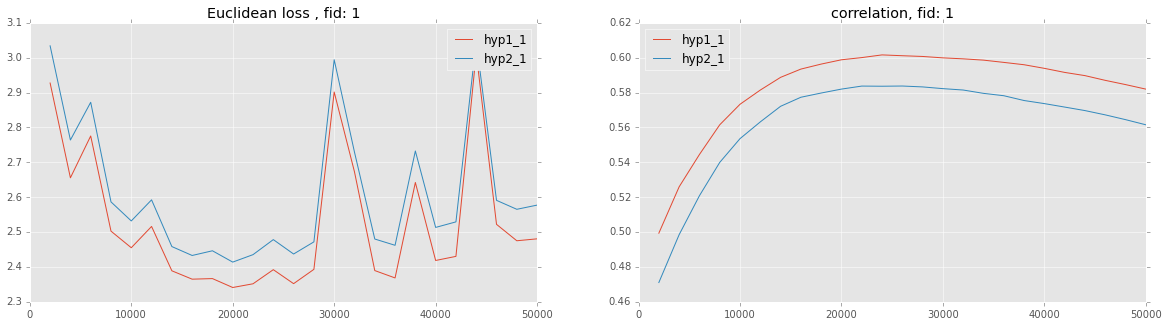

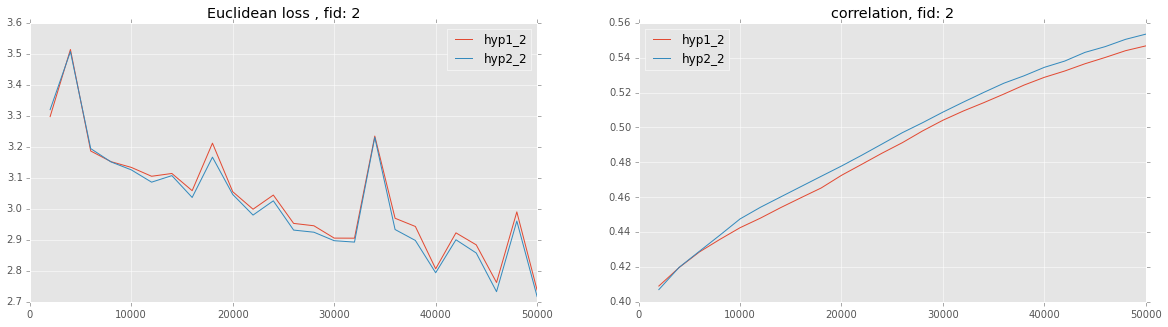

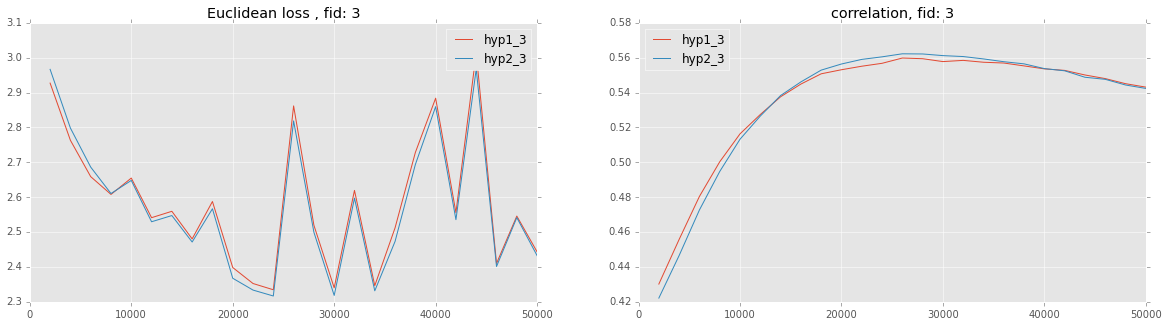

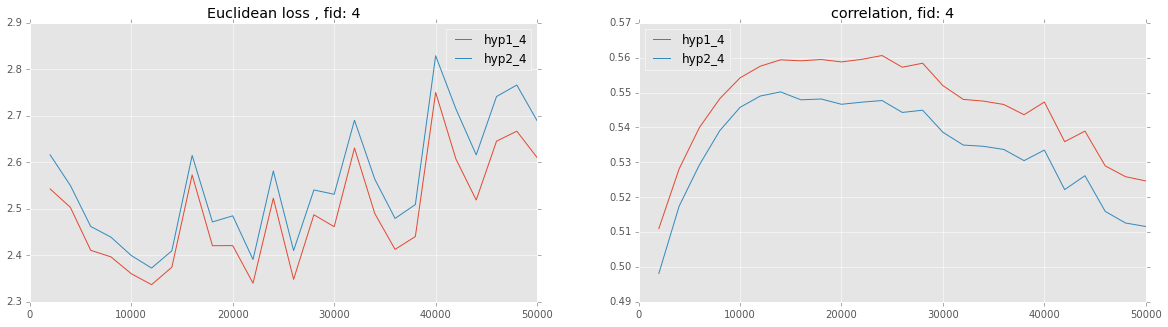

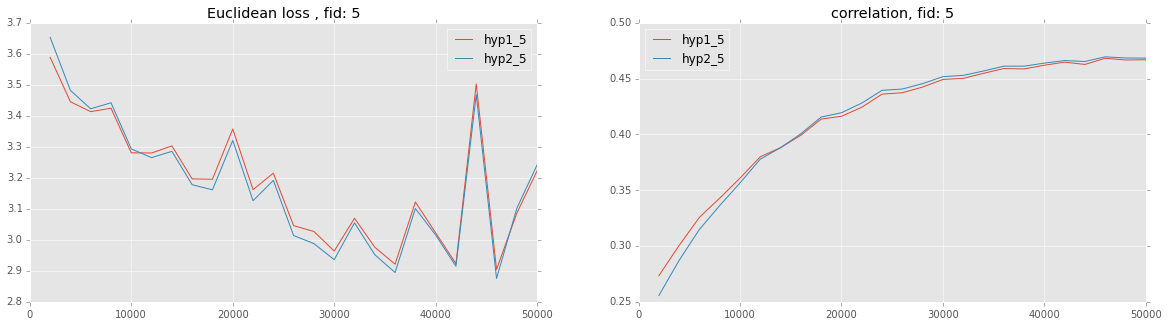

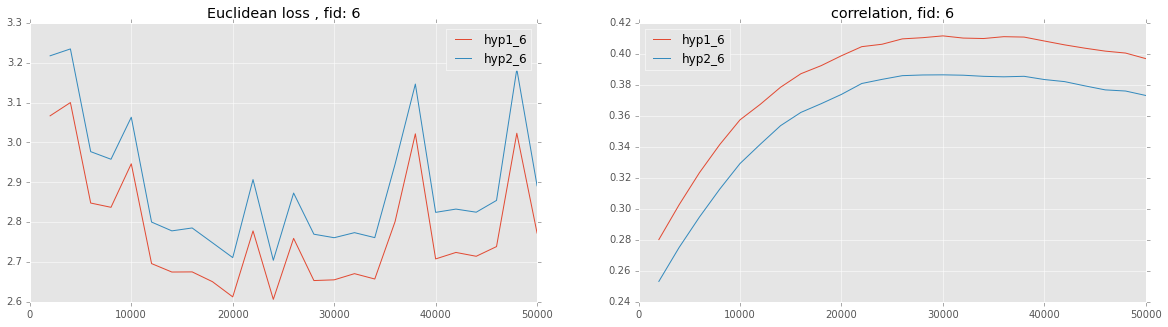

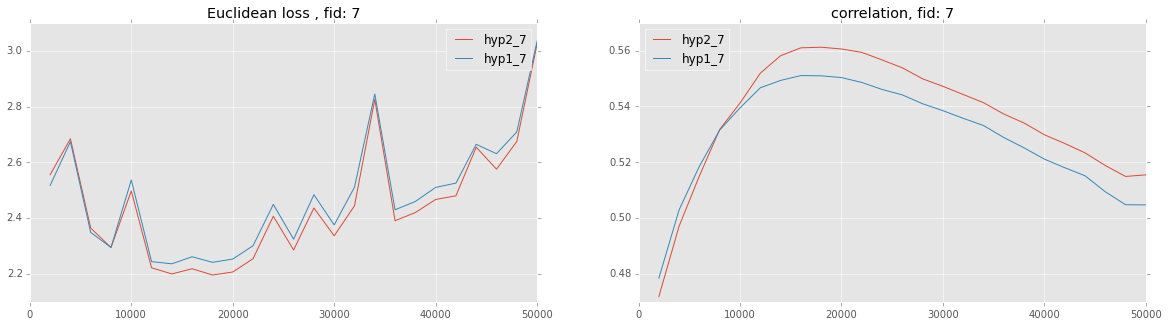

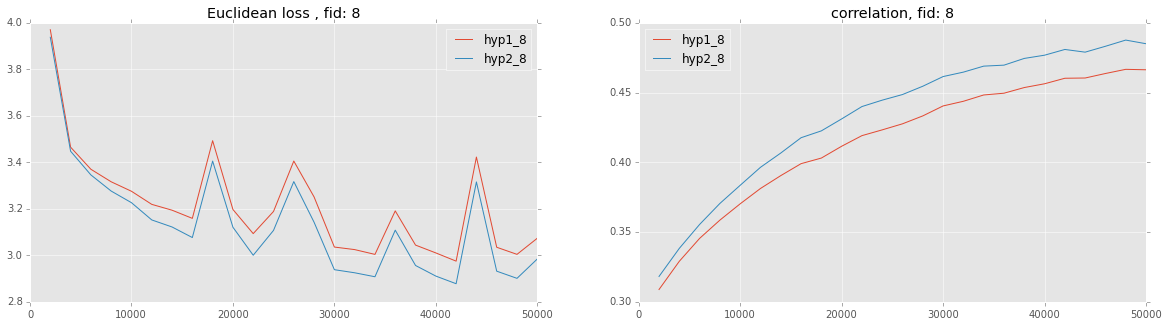

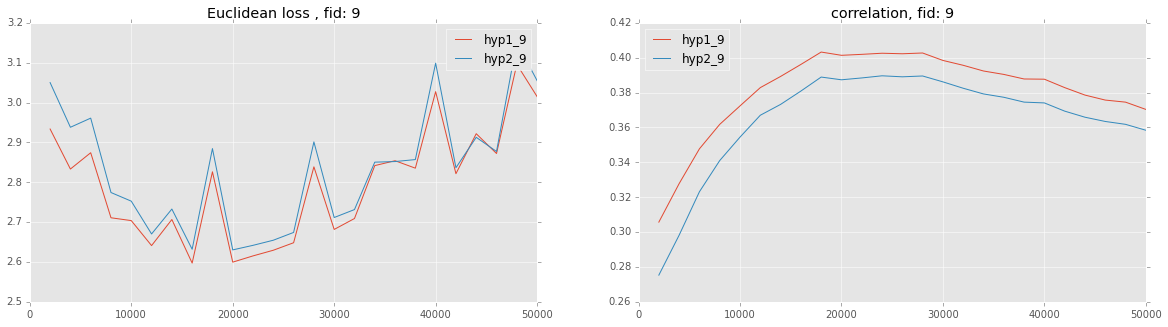

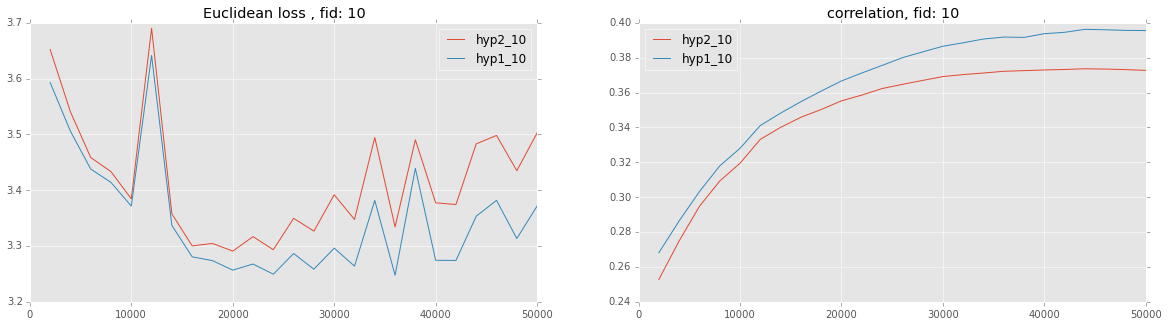

In [20]:
n_configs = len(fold_r)
plt.rcParams['figure.figsize'] = (20, 5)
n_rows = 1
n_cols = 2
pid = 1
for hype_fid in fold_euLoss.keys():
    hype = int(hype_fid.split('_')[0][3])
    fid = int(hype_fid.split('_')[1])    
    plt.figure(fid)
    plt.subplot(n_rows,n_cols,1)
    plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_euLoss[hype_fid],label=hype_fid)
    plt.title('Euclidean loss , fid: {}'.format(fid))
    plt.legend()
    plt.subplot(n_rows,n_cols,2)
    plt.plot(np.arange(snap_start,niter+1,snap_interval),fold_r[hype_fid],label=hype_fid)
    plt.title('correlation, fid: {}'.format(fid))
    plt.legend(loc=2)


In [21]:
# Find optimal config based on inner_test
snap_array = np.arange(snap_start,niter+1,snap_interval)
                    
fid_hype_map = defaultdict(list)
fid_euLoss_perf= defaultdict(list)
fid_r_perf= defaultdict(list)
for hype_fid in fold_euLoss.keys():
    hype = int(hype_fid.split('_')[0][3])
    fid = int(hype_fid.split('_')[1])
    fid_euLoss_perf[fid].append(fold_euLoss[hype_fid])
    fid_r_perf[fid].append(fold_r[hype_fid])
    fid_hype_map[fid].append(hype)

opt_r = []
opt_mse = []
opt_hype = []
actual_scores = []
opt_pred_scores = []

for fid in fid_hype_map.keys():
    r_perf_array = np.array(fid_r_perf[fid])
    euLoss_perf_array = np.array(fid_euLoss_perf[fid])
    
    h,snp = np.unravel_index(euLoss_perf_array.argmin(), euLoss_perf_array.shape)
    eu_loss = euLoss_perf_array[h,snp]
    opt_mse.append(2*eu_loss)
    print 'fid:{}, best hype:{}, snap: {}, euLoss:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],eu_loss)
    h,snp = np.unravel_index(r_perf_array.argmax(), r_perf_array.shape)
    r = r_perf_array[h,snp]
    opt_r.append(r)
    opt_hype.append(hype_configs['hyp{}'.format(fid_hype_map[fid][h])])
    print 'fid:{}, best hype:{}, snap: {}, r:{}'.format(fid, fid_hype_map[fid][h],snap_array[snp],r)
    actual_scores.append(fold_act_scores[fid])  
    opt_pred_scores.append(fold_pred_scores['hyp{}_{}'.format(fid_hype_map[fid][h],fid)][snp])
print 'CV Perf: r:{}, mse:{}'.format(np.mean(opt_r), np.mean(opt_mse))

fid:1, best hype:1, snap: 20000, euLoss:2.34100798303
fid:1, best hype:1, snap: 24000, r:0.601592342174
fid:2, best hype:2, snap: 50000, euLoss:2.71697445685
fid:2, best hype:2, snap: 50000, r:0.553496713615
fid:3, best hype:2, snap: 24000, euLoss:2.31664667108
fid:3, best hype:2, snap: 26000, r:0.562222750153
fid:4, best hype:1, snap: 12000, euLoss:2.33684669475
fid:4, best hype:1, snap: 24000, r:0.560617200129
fid:5, best hype:2, snap: 46000, euLoss:2.87548804137
fid:5, best hype:2, snap: 46000, r:0.469513549063
fid:6, best hype:1, snap: 24000, euLoss:2.60608242123
fid:6, best hype:1, snap: 30000, r:0.411560630817
fid:7, best hype:2, snap: 18000, euLoss:2.19605697882
fid:7, best hype:2, snap: 18000, r:0.561245363178
fid:8, best hype:2, snap: 42000, euLoss:2.87779035613
fid:8, best hype:2, snap: 48000, r:0.487611354098
fid:9, best hype:1, snap: 16000, euLoss:2.59715395696
fid:9, best hype:1, snap: 18000, r:0.403222480189
fid:10, best hype:1, snap: 36000, euLoss:3.24762675572
fid:10, b

In [ ]:
# [ 0.71701234  0.61863543  0.61467927  0.58095677  0.56149885  
#  0.49358655  0.62439393  0.59661303  0.56884812  0.58961076]


boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
# model_files = ['Exp7_ADNI2_ADAS13_NN_HC_CT_2016-05-01-13-46-16.pkl',
#                'Exp7_ADNI2_ADAS13_NN_HC_CT_2016-05-02-10-29-55.pkl', 'Exp7_ADNI2_ADAS13_NN_HC_CT_2016-05-03-19-02-13.pkl']

model_file = 'Exp6_ADNI1_ADAS13_NN_HC_CT_2016-05-04-19-15-01.pkl'
print model_file
CV_data = pickle.load(open(boxplots_dir + model_file,'rb'))
print 'old CV_r: {}'.format(CV_data['CV_r'])
print ''
print 'old mean(CV_r): {}, mean(MSE): {}'.format(np.mean(CV_data['CV_r']),np.mean(CV_data['CV_MSE']))
print ''
print 'old CV_mse: {}'.format(CV_data['CV_MSE'])

NN_results = {}
NN_results['CV_MSE'] = opt_mse
NN_results['CV_r'] = opt_r
NN_results['predicted_CV_scores'] = opt_pred_scores
NN_results['actual_CV_scores'] = actual_scores
NN_results['tid_snap_config_dict'] = opt_hype

# #Combine second saved perf file with the previous one
# model_file_2 = 'Exp11_ADNI2_ADAS13_NN_HC_CT_2016-05-06-00-03-01.pkl'
# print model_file
# NN_results = pickle.load(open(boxplots_dir + model_file_2,'rb'))

idx_pairs = {0:0,1:1,2:2,5:5,6:6,7:7,9:9}
updated_CV_data = update_fold_perf(boxplots_dir + model_file, NN_results, idx_pairs)
print ''
print 'new CV_r: {}'.format(updated_CV_data['CV_r'])
print ''
print 'new mean(CV_r): {}, mean(MSE): {}'.format(np.mean(updated_CV_data['CV_r']),np.mean(updated_CV_data['CV_MSE']))
print ''
print 'new CV_mse: {}'.format(updated_CV_data['CV_MSE'])

save_updated_perf = False
if save_updated_perf:
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp6_ADNI1_ADAS13_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(updated_CV_data, output)
    output.close()

In [ ]:
import pickle
import time
import datetime

def update_fold_perf(saved_perf_file, new_perf_dict,idx_pairs): #idx_pairs={'old_idx':new_idx}
    CV_data = pickle.load(open(saved_perf_file,'rb'))    
    for key in CV_data.keys():
        for idx in idx_pairs.keys():
            CV_data[key][idx] = new_perf_dict[key][idx_pairs[idx]]
        
    return CV_data

In [ ]:
HC (ADNI1)
fid:1, best hype:1, snap: 10000, euLoss:24.9804792275
fid:1, best hype:2, snap: 8000, r:0.618163002854
fid:2, best hype:1, snap: 12000, euLoss:25.967983131
fid:2, best hype:2, snap: 10000, r:0.590332098517
fid:3, best hype:1, snap: 14000, euLoss:34.8323371747
fid:3, best hype:1, snap: 14000, r:0.513585520325
fid:4, best hype:2, snap: 18000, euLoss:30.0616446921
fid:4, best hype:2, snap: 10000, r:0.562053923318
fid:5, best hype:1, snap: 8000, euLoss:45.2696952675
fid:5, best hype:2, snap: 6000, r:0.484386218568
fid:6, best hype:1, snap: 8000, euLoss:36.2613456917
fid:6, best hype:1, snap: 8000, r:0.448447097693
fid:7, best hype:1, snap: 6000, euLoss:25.3728563975
fid:7, best hype:2, snap: 4000, r:0.569872808577
fid:8, best hype:2, snap: 10000, euLoss:24.2016694373
fid:8, best hype:2, snap: 8000, r:0.529221803897
fid:9, best hype:1, snap: 8000, euLoss:27.0590434962
fid:9, best hype:2, snap: 14000, r:0.476044796782
fid:10, best hype:1, snap: 12000, euLoss:33.7379212677
fid:10, best hype:1, snap: 20000, r:0.511206989432
CV Perf: r:0.530331425996, mse:61.5489951566
            
CT (ADNI1)
fid:1, best hype:4, snap: 26000, euLoss:25.8350339172
fid:1, best hype:4, snap: 28000, r:0.580744990132
fid:2, best hype:1, snap: 20000, euLoss:27.4633322097
fid:2, best hype:1, snap: 30000, r:0.539312798756
fid:3, best hype:1, snap: 24000, euLoss:32.985009536
fid:3, best hype:4, snap: 18000, r:0.550124971628
fid:4, best hype:4, snap: 8000, euLoss:39.0047762008
fid:4, best hype:3, snap: 40000, r:0.385853287133
fid:5, best hype:2, snap: 12000, euLoss:36.2558308892
fid:5, best hype:3, snap: 16000, r:0.518366572313
fid:6, best hype:4, snap: 26000, euLoss:33.4368286296
fid:6, best hype:4, snap: 32000, r:0.519355577479
fid:7, best hype:4, snap: 8000, euLoss:26.6360230396
fid:7, best hype:4, snap: 10000, r:0.480488994696
fid:8, best hype:2, snap: 8000, euLoss:25.9672358442
fid:8, best hype:4, snap: 16000, r:0.47992385987
fid:9, best hype:3, snap: 8000, euLoss:23.7660096974
fid:9, best hype:2, snap: 12000, r:0.515238620828
fid:10, best hype:3, snap: 40000, euLoss:34.3815763364
fid:10, best hype:2, snap: 38000, r:0.527298506806
CV Perf: r:0.509670817964, mse:61.14633126
            
HC_CT (ADNI1) 
fid:1, best hype:6, snap: 14000, euLoss:21.8368207263
fid:1, best hype:6, snap: 14000, r:0.665541584179
fid:2, best hype:8, snap: 20000, euLoss:24.492447482
fid:2, best hype:8, snap: 20000, r:0.592235431033
fid:3, best hype:8, snap: 20000, euLoss:29.2468359
fid:3, best hype:8, snap: 20000, r:0.614328598919
fid:4, best hype:6, snap: 12000, euLoss:30.1642826759
fid:4, best hype:6, snap: 10000, r:0.536940060297
fid:5, best hype:2, snap: 16000, euLoss:33.9339476376
fid:5, best hype:2, snap: 16000, r:0.561498850486
fid:6, best hype:8, snap: 14000, euLoss:35.6290443771
fid:6, best hype:8, snap: 16000, r:0.461981628273
fid:7, best hype:6, snap: 12000, euLoss:21.0467020887
fid:7, best hype:6, snap: 12000, r:0.624393932281
fid:8, best hype:2, snap: 18000, euLoss:21.1833302525
fid:8, best hype:2, snap: 18000, r:0.596613031213
fid:9, best hype:7, snap: 16000, euLoss:23.4504655627
fid:9, best hype:8, snap: 20000, r:0.549850038264
fid:10, best hype:6, snap: 20000, euLoss:29.4776804418
fid:10, best hype:6, snap: 20000, r:0.579462867606
CV Perf: r:0.578284602255, mse:54.0923114289

fid:1, best hype:4, snap: 12000, euLoss:19.385883703
fid:1, best hype:4, snap: 12000, r:0.717012338726
fid:2, best hype:4, snap: 12000, euLoss:23.2118685134
fid:2, best hype:4, snap: 12000, r:0.618635434743
fid:3, best hype:2, snap: 16000, euLoss:28.9700777636
fid:3, best hype:3, snap: 14000, r:0.614679267678
fid:4, best hype:3, snap: 12000, euLoss:27.6156180904
fid:4, best hype:3, snap: 12000, r:0.580956772823
fid:5, best hype:2, snap: 12000, euLoss:34.3337375218
fid:5, best hype:4, snap: 10000, r:0.558080830398
fid:6, best hype:1, snap: 14000, euLoss:35.2833445481
fid:6, best hype:1, snap: 14000, r:0.493586554303
fid:7, best hype:3, snap: 8000, euLoss:21.561520043
fid:7, best hype:2, snap: 10000, r:0.604751678545
fid:8, best hype:4, snap: 8000, euLoss:22.6269883545
fid:8, best hype:2, snap: 16000, r:0.578988034023
fid:9, best hype:1, snap: 12000, euLoss:22.5312161778
fid:9, best hype:1, snap: 16000, r:0.568848116216
fid:10, best hype:4, snap: 14000, euLoss:29.1751097441
fid:10, best hype:4, snap: 14000, r:0.589610760215
CV Perf: r:0.592514978767, mse:52.9390728919

            
HC (ADNI2)
fid:1, best hype:3, snap: 18000, euLoss:31.1006562908
fid:1, best hype:1, snap: 30000, r:0.586353688344
fid:2, best hype:3, snap: 26000, euLoss:32.9662736235
fid:2, best hype:3, snap: 24000, r:0.669333897132
fid:3, best hype:2, snap: 36000, euLoss:30.384235121
fid:3, best hype:2, snap: 40000, r:0.544646225582
fid:4, best hype:2, snap: 32000, euLoss:26.8515617888
fid:4, best hype:2, snap: 26000, r:0.606256451398
fid:5, best hype:3, snap: 36000, euLoss:45.8194681009
fid:5, best hype:1, snap: 18000, r:0.517164527931
fid:6, best hype:4, snap: 40000, euLoss:24.0025679138
fid:6, best hype:4, snap: 40000, r:0.62570107699
fid:7, best hype:1, snap: 16000, euLoss:50.5119887715
fid:7, best hype:3, snap: 24000, r:0.408465338901
fid:8, best hype:4, snap: 30000, euLoss:32.3904189083
fid:8, best hype:4, snap: 40000, r:0.537722161255
fid:9, best hype:2, snap: 38000, euLoss:39.3835394087
fid:9, best hype:2, snap: 40000, r:0.49499395939
fid:10, best hype:2, snap: 12000, euLoss:37.8077445797
fid:10, best hype:2, snap: 10000, r:0.57777398392
CV Perf: r:0.556841131084, mse:70.2436909014
            
CT (ADNI2)
fid:1, best hype:4, snap: 40000, euLoss:31.564576893
fid:1, best hype:4, snap: 40000, r:0.535450818923
fid:2, best hype:4, snap: 32000, euLoss:26.624324672
fid:2, best hype:4, snap: 34000, r:0.733523463006
fid:3, best hype:4, snap: 32000, euLoss:21.5213626512
fid:3, best hype:4, snap: 20000, r:0.711414187155
fid:4, best hype:2, snap: 30000, euLoss:26.0918774873
fid:4, best hype:2, snap: 22000, r:0.628084544407
fid:5, best hype:4, snap: 40000, euLoss:37.9048385987
fid:5, best hype:4, snap: 40000, r:0.591108478187
fid:6, best hype:4, snap: 26000, euLoss:27.6405805728
fid:6, best hype:4, snap: 40000, r:0.567989262491
fid:7, best hype:3, snap: 22000, euLoss:37.3339119496
fid:7, best hype:1, snap: 40000, r:0.606678494326
fid:8, best hype:2, snap: 38000, euLoss:24.0600832735
fid:8, best hype:2, snap: 38000, r:0.651449306233
fid:9, best hype:4, snap: 38000, euLoss:29.1995566658
fid:9, best hype:4, snap: 38000, r:0.642322450054
fid:10, best hype:3, snap: 22000, euLoss:34.1581885294
fid:10, best hype:4, snap: 32000, r:0.598128556457
CV Perf: r:0.626614956124, mse:59.2198602587

HC (ADNI1+ADNI2)
fid:1, best hype:4, snap: 16000, euLoss:25.5427257732
fid:1, best hype:1, snap: 20000, r:0.635262286181
fid:2, best hype:4, snap: 36000, euLoss:28.007589395
fid:2, best hype:2, snap: 32000, r:0.640702711425
fid:3, best hype:4, snap: 36000, euLoss:31.3078344445
fid:3, best hype:2, snap: 28000, r:0.562932234264
fid:4, best hype:4, snap: 34000, euLoss:28.8538741144
fid:4, best hype:4, snap: 22000, r:0.581952986768
fid:5, best hype:4, snap: 28000, euLoss:40.9219323271
fid:5, best hype:4, snap: 28000, r:0.513852217676
fid:6, best hype:4, snap: 28000, euLoss:31.9896590757
fid:6, best hype:2, snap: 40000, r:0.514971207915
fid:7, best hype:4, snap: 18000, euLoss:38.4145699362
fid:7, best hype:2, snap: 14000, r:0.46256342695
fid:8, best hype:2, snap: 32000, euLoss:28.4115783735
fid:8, best hype:1, snap: 40000, r:0.518761400372
fid:9, best hype:4, snap: 28000, euLoss:33.7696027174
fid:9, best hype:2, snap: 36000, r:0.482283921963
fid:10, best hype:4, snap: 16000, euLoss:37.4498623203
fid:10, best hype:2, snap: 14000, r:0.515666128844
CV Perf: r:0.542894852236, mse:64.9338456955
            
CT (ADNI1+ADNI2)
fid:1, best hype:1, snap: 32000, euLoss:29.830174769
fid:1, best hype:1, snap: 40000, r:0.532392927922
fid:2, best hype:2, snap: 40000, euLoss:28.0781115603
fid:2, best hype:2, snap: 40000, r:0.636745029524
fid:3, best hype:1, snap: 40000, euLoss:26.6943931513
fid:3, best hype:2, snap: 26000, r:0.655258153866
fid:4, best hype:4, snap: 26000, euLoss:33.4955111359
fid:4, best hype:4, snap: 30000, r:0.492795606363
fid:5, best hype:2, snap: 38000, euLoss:37.4164549165
fid:5, best hype:2, snap: 34000, r:0.558587798746
fid:6, best hype:2, snap: 34000, euLoss:29.5190398753
fid:6, best hype:2, snap: 40000, r:0.561838293275
fid:7, best hype:2, snap: 10000, euLoss:34.8524304954
fid:7, best hype:1, snap: 12000, r:0.488013116528
fid:8, best hype:4, snap: 32000, euLoss:24.5997470284
fid:8, best hype:4, snap: 40000, r:0.594486998119
fid:9, best hype:2, snap: 38000, euLoss:28.5725313744
fid:9, best hype:2, snap: 40000, r:0.570555072946
fid:10, best hype:2, snap: 26000, euLoss:35.9999022312
fid:10, best hype:2, snap: 36000, r:0.52921470762
CV Perf: r:0.561988770491, mse:61.8116593076
            
HC_CT (ADNI1+ADNI2)
fid:1, best hype:4, snap: 18000, euLoss:26.5206985927
fid:1, best hype:4, snap: 18000, r:0.599511137562
fid:2, best hype:2, snap: 28000, euLoss:30.5457669599
fid:2, best hype:2, snap: 32000, r:0.592150226726
fid:3, best hype:1, snap: 38000, euLoss:30.3515014599
fid:3, best hype:1, snap: 40000, r:0.579741031528
fid:4, best hype:3, snap: 32000, euLoss:30.0210360115
fid:4, best hype:3, snap: 34000, r:0.552430441356
fid:5, best hype:3, snap: 28000, euLoss:39.182075602
fid:5, best hype:3, snap: 28000, r:0.523933996482
fid:6, best hype:4, snap: 40000, euLoss:33.234443951
fid:6, best hype:4, snap: 40000, r:0.488648456284
fid:7, best hype:2, snap: 18000, euLoss:34.6361386606
fid:7, best hype:2, snap: 24000, r:0.491865758471
fid:8, best hype:2, snap: 24000, euLoss:26.6209951932
fid:8, best hype:2, snap: 26000, r:0.548111760686
fid:9, best hype:3, snap: 28000, euLoss:32.9634885617
fid:9, best hype:4, snap: 40000, r:0.465846376987
fid:10, best hype:2, snap: 16000, euLoss:35.1673696246
fid:10, best hype:2, snap: 16000, r:0.524438537544
CV Perf: r:0.536667772362, mse:63.8487029234


In [22]:
import time
import datetime

#print 'modality: {} mse: {}, r: {}'.format(modality, np.mean(2*np.array(fold_euLoss)[:,-1]),np.mean(np.array(fold_r)[:,-1]))
#CV_perf ={'fid_list': fid_hype_map.keys(), 'hype_configs':opt_hype,'fold_mse':opt_mse,'fold_r':opt_r}
#pickleIt(CV_perf, baseline_dir + 'API/CV_perf/outer_test_{}.pkl'.format(modality))
#print "Saving opt perf for fids: {} with modality: {}".format(fid_hype_map.keys(),modality)
print opt_r
print opt_mse

save_detailed_results = True

if save_detailed_results:
    # dictionaries for summarized results
    NN_results = {}

    NN_results['CV_MSE'] = opt_mse
    NN_results['CV_r'] = opt_r
    NN_results['predicted_CV_scores'] = opt_pred_scores
    NN_results['actual_CV_scores'] = actual_scores
    NN_results['tid_snap_config_dict'] = opt_hype
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    montage_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'  
    save_name = '{}Exp6_ADNI1_MMSE_NN_{}_{}.pkl'.format(montage_dir,modality,st)
    print 'saving results at: {}'.format(save_name)
    output = open(save_name, 'wb')
    pickle.dump(NN_results, output)
    output.close()

[0.60159234217414226, 0.55349671361488983, 0.56222275015320577, 0.56061720012881922, 0.46951354906280413, 0.41156063081728084, 0.5612453631780433, 0.48761135409810313, 0.40322248018903029, 0.39625323268080065]
[4.6820159660651104, 5.4339489136982593, 4.6332933421593703, 4.6736933895060835, 5.7509760827495162, 5.2121648424615712, 4.3921139576403663, 5.7555807122665676, 5.1943079139191051, 6.4952535114455925]
saving results at: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/Exp6_ADNI1_MMSE_NN_CT_2016-05-10-21-28-16.pkl


In [ ]:
import pickle
boxplots_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/'
model_file = 'Exp6_ADNI1_ADAS13_NN_HC_CT_2016-04-25-13-26-25.pkl'
CV_data = pickle.load(open(boxplots_dir + model_file,'rb'))

opt_mse = CV_data['CV_MSE']
opt_r = CV_data['CV_r']
opt_hype = CV_data['tid_snap_config_dict']
#actual_scores = []
#opt_pred_scores = []
print np.mean(np.array(opt_mse))
print np.mean(np.array(opt_r))
print opt_r[4], opt_hype[4]

a = [0.71701233872649583, 0.61863543474266547, 0.61467926767752157, 0.58095677282250102, 0.55808083039804779, 
     0.49358655430330067, 0.60475167854479739, 0.57898803402319077, 0.56884811621626763, 0.58961076021473602]

b = [0.71671762632760383, 0.61621460856727428, 0.61134923509603034, 0.58863609091191105, 0.55675880434099656, 
     0.47100346323317155, 0.58819413911512908, 0.56460945813269181, 0.57653317702204721, 0.59351872839470088]

perf_concat = np.vstack((np.array(opt_r),np.array(a),np.array(b)))
print np.max(perf_concat,axis=0)
print np.mean(np.max(perf_concat,axis=0))

In [5]:
# Some defs to load data and extract encodings from trained net
import tables as tb
from sklearn import preprocessing
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

import collections
def extract_features(net_file, model_file, data_path, input_nodes, batch_size, encoding_layer, weight_layers):
    os.chdir(os.path.dirname(net_file))
    net = caffe.Net(net_file, model_file, caffe.TEST)        
    
    print net.blobs.items()[0]
    print net.blobs.items()[1]
    
    #Get weights    
    layer_list = weight_layers
    wt_dict = collections.OrderedDict()
    for l, name in enumerate(net._layer_names):            
        if name in layer_list:
            wt_dict[name] = net.layers[l].blobs[0].data
    
    BATCH_SIZE = batch_size        
    N = load_data(data_path, input_nodes[0],'no_preproc').shape[0]
    iters = int(np.ceil(N / float(BATCH_SIZE)))

    code_layer = net.blobs[encoding_layer]
    out_shape = code_layer.data.shape    
    X_out = np.zeros(shape=(N, out_shape[1]))
    
    X_list = []
    data_layers = []
    for i, input_node in enumerate(input_nodes):
        X_list.append(load_data(data_path, input_node,'no_preproc'))
        data_layers.append(net.blobs.items()[i][1])    
        data_layers[i].reshape(BATCH_SIZE, X_list[i].shape[1]) # TODO: only works for 2-D inputs
    
    net.reshape()
        
    print 'Extracting features from data...'
    print 'X_out.shape: {}'.format(X_out.shape)
    
    for i in xrange(iters):
        print '.',
        for m, X in enumerate(X_list):
            X_b = X[i * BATCH_SIZE: (i+1) * BATCH_SIZE,:]
            batch_sampx = X_b.shape[0]
            # Pad last batch with zeros
            if X_b.shape[0] < BATCH_SIZE:
                #print 'Zero-padding last batch with {} rows'.format(BATCH_SIZE-X_b.shape[0])
                X_b = np.vstack((X_b,np.zeros((BATCH_SIZE-X_b.shape[0],X_b.shape[1]))))                       
            
            data_layers[m].data[...] = X_b
            
        net.forward()
        X_out[i * BATCH_SIZE: min((i+1) * BATCH_SIZE, N)] = code_layer.data[0:batch_sampx,:].copy()

    return {'X_out':X_out, 'wt_dict':wt_dict}

def generate_APIdata(in_data_path,out_data_path,fid,modality,preproc, CS_only):
    print in_data_path
    #Input config file generation
    in_data = load_data(in_data_path, 'Fold_{}_X_{}'.format(fid,modality), preproc)
    # get labels (no_preproc)        

    # HDF5 is pretty efficient, but can be further compressed.
    comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
    with h5py.File(out_data_path, 'a') as f:
        if not CS_only:
            if modality == 'R_CT': #Fix the typo
                in_label = load_data(in_data_path, 'Fold_{}_y'.format(fid), 'no_preproc')
                modality = 'CT'
                f.create_dataset('y', data=in_label, **comp_kwargs)
                in_label = load_data(in_data_path, 'Fold_{}_y3'.format(fid), 'no_preproc')
                f.create_dataset('y3', data=in_label, **comp_kwargs)

            f.create_dataset('X_{}'.format(modality), data=in_data, **comp_kwargs)
        else:
            if modality == 'R_CT': #Fix the typo
                in_label = load_data(in_data_path, 'Fold_{}_y3'.format(fid), 'no_preproc')
                f.create_dataset('y3', data=in_label, **comp_kwargs)
        

In [6]:
#Generate API style data (options: scale / normalize)
exp_name = 'Exp6'
exp_name_out = 'Exp6'
#cohorts = ['inner_train','inner_test','outer_test']
cohorts = ['outer_test']
preproc = 'no_preproc'
modalities = ['L_HC','R_HC','R_CT']
dataset = 'ADNI1'
CS_only = False

for fid in np.arange(1,11,1):
    for modality in modalities:
        for cohort in cohorts:
            if cohort == 'inner_train':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_{}_ADAS13_NN_OuterFold_{}_train_InnerFold_1.h5'.format(exp_name,dataset,fid)
            elif cohort == 'inner_test':
                in_data_path = baseline_dir + 'caffe_input/CV_{}_{}_ADAS13_NN_OuterFold_{}_valid_InnerFold_1.h5'.format(exp_name,dataset,fid)
            else:
                in_data_path = baseline_dir + 'CV_{}_{}_ADAS13_NN_valid.h5'.format(exp_name,dataset)

            out_data_path = baseline_dir + 'API/data/fold{}/{}/{}_{}.h5'.format(fid,cohort,exp_name_out,preproc)

            generate_APIdata(in_data_path,out_data_path,fid,modality,preproc, CS_only)

/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_ADNI1_ADAS13_NN_valid.h5
/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/CV_Exp6_AD

In [ ]:
# Net surgery AE --> FF pretrained weights
#Review new FF net params
modality = 'HC_CT'
n_folds = 8
for fid in np.arange(1,n_folds+1,1):
    print 'fid: {}'.format(fid)
    for AE_branch in ['CT','R_HC','L_HC']:
        print 'AE_branch: {}'.format(AE_branch)

        if AE_branch == 'L_HC':
            params_FF = ['L_ff1', 'L_ff2']
            AE_iter = 10000
        elif AE_branch == 'R_HC':
            params_FF = ['R_ff1', 'R_ff2']
            AE_iter = 10000
        elif AE_branch == 'CT':
            params_FF = ['ff1', 'ff2']
            AE_iter = 50000
            #fid for pretain is 1 because it's same definition for all the folds.
            #Only use this during 1 of the modalities to avoid overwritting
            print 'Spawning new net'
            pretrain_net = caffe.Net(baseline_dir + 'API/data/fold{}/ADNI_FF_pretrain.prototxt'.format(1), caffe.TRAIN)
        else:
            print 'Wrong AE branch'

        # conv_params = {name: (weights, biases)}
        conv_params = {pr: (pretrain_net.params[pr][0].data, pretrain_net.params[pr][1].data) for pr in params_FF}

        for conv in params_FF:
            print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

        # Review AE net params 
        #fid for pretain is 1 because it's same definition for all the folds.
        net_file = baseline_dir + 'API/data/fold{}/ADNI_AE_{}_test.prototxt'.format(1,AE_branch)
        model_file = baseline_dir + 'API/data/fold{}/train_snaps/AE_snaps/AE_{}_iter_{}.caffemodel'.format(fid,AE_branch,AE_iter) 

        AE_net = caffe.Net(net_file, model_file, caffe.TEST)
        params_AE = ['encoder1', 'code']
        # fc_params = {name: (weights, biases)}
        fc_params = {pr: (AE_net.params[pr][0].data, AE_net.params[pr][1].data) for pr in params_AE}

        for fc in params_AE:
            print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

        #transplant net parameters
        for pr, pr_conv in zip(params_AE, params_FF):
            conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
            conv_params[pr_conv][1][...] = fc_params[pr][1]

        save_net = True
        if save_net:
            save_path = baseline_dir + 'API/data/fold{}/pretrained_models/adni_ff_{}_iter_{}_concat50.caffemodel'.format(fid,modality,AE_iter)
            print "Saving net to " + save_path
            pretrain_net.save(save_path)

In [ ]:
import pickle
CT_data = pickle.load(open('/projects/nikhil/ADNI_prediction/input_datasets/exp_data/NN/montage_data/Exp4_ADNI1_ADAS13_NN_CT_2016-03-01-11-18-48.pkl','rb'))
CT_data.keys()

In [ ]:
pred = fold_pred_scores['hyp1_1'][5] #CT_data['predicted_CV_scores'][1]
act = fold_act_scores[1] #CT_data['actual_CV_scores'][1]
print act
#print CT_data['tid_snap_config_dict']
print 'Euclidean loss: {}'.format(0.5*mse(pred,act))
print stats.pearsonr(pred,act)
plt.scatter(pred,act)

In [ ]:
fold_pred_scores['hyp1_1'][5]

In [ ]:
fid = 1
exp_name = 'Exp6'
preproc = 'no_preproc'
train_filename_hdf = baseline_dir + 'API/data/fold{}/inner_train/{}_{}.h5'.format(fid,exp_name,preproc)
inner_test_filename_hdf = baseline_dir + 'API/data/fold{}/inner_test/{}_{}.h5'.format(fid,exp_name,preproc)
outer_test_filename_hdf = baseline_dir + 'API/data/fold{}/outer_test/{}_{}.h5'.format(fid,exp_name,preproc)
train_data = load_data(train_filename_hdf, 'X_R_HC', preproc)
inner_test_data = load_data(inner_test_filename_hdf, 'X_R_HC', preproc)
outer_test_data = load_data(outer_test_filename_hdf, 'X_R_HC', preproc)
train_y = load_data(train_filename_hdf, 'y', preproc)
inner_test_y = load_data(inner_test_filename_hdf, 'y', preproc)
outer_test_y = load_data(outer_test_filename_hdf, 'y', preproc)


In [ ]:
print train_data.shape, inner_test_data.shape, outer_test_data.shape
print np.mean(np.sum(train_data,axis=1)), np.mean(np.sum(inner_test_data,axis=1)), np.mean(np.sum(outer_test_data,axis=1))
print np.mean(train_y), np.mean(inner_test_y), np.mean(outer_test_y)

In [ ]:
(17358, 16086) (4340, 16086) (71, 16086)
3377.85793294 3403.70506912 3427.98591549
15.4938933057 15.7380184332 15.7605633803

In [ ]:
16086,16471